In [1]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

C:\Users\user\Anaconda3\lib\site-packages\wheel\pep425tags.py:75: RuntimeWarning: Config variable 'Py_DEBUG' is unset, Python ABI tag may be incorrect
  warn=(impl == 'cp')):
C:\Users\user\Anaconda3\lib\site-packages\wheel\pep425tags.py:79: RuntimeWarning: Config variable 'WITH_PYMALLOC' is unset, Python ABI tag may be incorrect
  warn=(impl == 'cp')):
torch-0.4.1-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.0.0
False


In [3]:
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [4]:
# torch.device()를 통해 gpu를 이용합니다. 
# cuda:뒤의 번호는 gpu를 여러개 동시 사용할 때 쓰이는 gpu 번호입니다.
# gpu 사용이 가능한 경우 torch.cuda.is_available() = True이고 아닌 경우 False가 됩니다.

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Load Data & Preprocessing

In [5]:
# 우선 dataset을 불러와 정규화를 해야 합니다.

# torchvision.transforms.Compose() 여러개의 transform을 구성합니다.
# totensor, normalize를 구성합니다.
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

# trainset
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)

# testset
testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False, 
                                       download=True, 
                                       transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# num_workers는 사용하는 cpu의 갯수를 뜻합니다. batch_size = 4입니다.

trainloader = torch.utils.data.DataLoader(trainset,batch_size = 4,shuffle = True)

testloader = torch.utils.data.DataLoader(testset,batch_size=4, shuffle = False)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

horse   cat  deer   cat


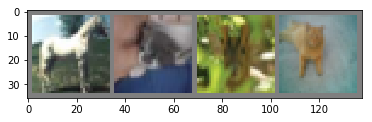

In [7]:

# 우리가 분류하는 image 예시를 한번 보고 가겠습니다.

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# image show 함수
# torchvision.utils.make_grid(images) 는 -1 ~ 1의 범위를 갖습니다. 
# plot을 그리기 위해 우선 0~1 범위로 변경합니다.
# numpy()로 넣어주고 가로로 4개의 이미지를 보여주기 위해 transpose로 차원 위치를 변경합니다.

def imshow(img):
    img = img / 2 +0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))

# 학습용 이미지를 iter()로 하나씩 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

#정답 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#이미지 보여주기
imshow(torchvision.utils.make_grid(images))

In [8]:

torchvision.utils.make_grid(images).shape

torch.Size([3, 36, 138])

## Modeling

In [9]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        
        # 이제 3채널 이미지를 처리합니다
        # 32 X 32 X 3 X batch_size
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,6,kernel_size=5,stride=1,padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2)
        )
        # 14 X 14 X 6 X batch_size
        self.layer2 = nn.Sequential(
            nn.Conv2d(6,16,kernel_size=5, stride = 1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
            )
        # 5 X 5 X 16 X batch_size
    
        self.fc1 = nn.Sequential(
                        nn.Linear(5*5*16,120),
                        nn.ReLU()
                        )
        self.fc2 = nn.Sequential(
                        nn.Linear(120,84),
                        nn.ReLU()
                        )
    
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,x):
        
        # conv1(), 32X32인데 kernel_size = 5X5, stride = 1, padding = 0 즉 output은 28X28X6
        # pool(), 28X28를 kernel_size = 2X2, stride = 2로 pooling합니다. output은 14X14X6
        
        x = self.layer1(x)
        
        # conv2(), 14X14X6, kernel_size = 5X5, stride = 1, padding = 0 output은 10 X10 X 160
        # pool(), 10 X 10 를 kernel_size = 2X2, stride = 2로 pooling output은  5X5X16
        
        x = self.layer2(x)
        
        x = x.reshape(x.size(0),-1) # batchsize를 제외한 나머지들의 곱
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x
    
net = ConvNet()
    
if torch.cuda.is_available():
     net = ConvNet().to(device)
    
    

## Loss function & Optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

## Training

In [11]:
for epoch in range(2): 
    running_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        
        # 입력을 받습니다
        
        if torch.cuda.is_available():
            images = images.to(device)
            labels = labels.tp(device)
            
        # Feed forward
        
        outputs = net(images)
        loss = criterion(outputs, labels)
        
        # Back prop and update weight
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # loss출력
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d,%5d] loss: %.3f' % (epoch +1, i+1, running_loss/2000))
            running_loss = 0.0
            
print("Finished Training")

[1, 2000] loss: 2.176
[1, 4000] loss: 1.944
[1, 6000] loss: 1.707
[1, 8000] loss: 1.594
[1,10000] loss: 1.489
[1,12000] loss: 1.472
[2, 2000] loss: 1.383
[2, 4000] loss: 1.359
[2, 6000] loss: 1.352
[2, 8000] loss: 1.297
[2,10000] loss: 1.271
[2,12000] loss: 1.262
Finished Training


## Evaluation

GroudTruth:    cat  ship  ship plane


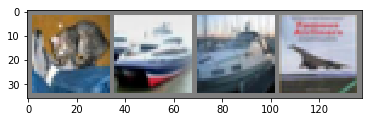

In [12]:
dataiter = iter(testloader) # iter, next 를 이용해 test data 하나씩 꺼내옵니다.
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroudTruth: ',' '.join('%5s' % classes[labels[j]] for j in range(4))) # 시험용 데이터 4개를 출력합니다

In [13]:
correct = 0
total = 0 


with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs =  net(images)
        _, predicted = torch.max(outputs.data,1) # 0은 각레이블당 출력값 1은 레이블 인덳,
        total += labels.size(0)                  # batch_size만큼 더해짐
        correct += (predicted == labels).sum().item() # Longtensor 와 그냥 Tensor의 차이가 뭘까
        
print('Accuracy of the network on the 10000 test images: %d %%' %(100*correct/total))
# 저네 데이터 셋에 대해서 55%의 정확도를 보인다. 

Accuracy of the network on the 10000 test images: 55 %


In [14]:
for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = net(images)
    print(labels.long())
    if 1:
        break

tensor([3, 8, 8, 0])


In [15]:
for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = net(images)
    print(outputs)
    if 1:
        break
## barch_size 4만큼 각 레이블의 값들이 출력

tensor([[-1.8494, -1.7648,  1.7642,  3.0073,  0.4692,  0.8916,  2.2380, -1.8261,
         -1.0250, -2.1232],
        [ 6.9639,  6.8948, -1.8252, -3.0370, -3.6392, -6.2238, -6.0346, -4.7519,
          4.9396,  4.7508],
        [ 3.6008,  3.0427, -0.1436, -1.4834, -1.7962, -3.0807, -2.6528, -3.6546,
          3.7374,  1.1013],
        [ 4.4302,  0.4226,  0.6541, -1.4140,  0.5397, -3.9685, -3.5945, -2.2159,
          2.4953,  1.1922]], grad_fn=<AddmmBackward>)


In [16]:
for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = net(images)
    print(torch.max(outputs.data,1))
    if 1:
        break
## batch_size만큼 출력됐는데 첫번째 test_data 셋의 각 레이브당 출력값중 가장 큰 2.2247이 뽑히고 옆에는 index
    

(tensor([3.0073, 6.9639, 3.7374, 4.4302]), tensor([3, 0, 8, 0]))


In [19]:
for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)
       
    outputs = net(images)
    _, predicted = torch.max(outputs,1)
    c = (predicted == labels).squeeze()
    print(c)
    for i in range(4):
        print(c[i])
    if 1:
        break #

tensor([1, 0, 1, 1], dtype=torch.uint8)
tensor(1, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(1, dtype=torch.uint8)
tensor(1, dtype=torch.uint8)


## 각 라벨별 accuracy 뽑기

In [20]:
for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)
        
    outputs = net(images)
    _, predicted = torch.max(outputs,1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        print(labels[i])
    if 1:
        break

tensor(3)
tensor(8)
tensor(8)
tensor(0)


In [21]:
class_correct= list(0 for i in range(10)) # 빈 리스트 생성
class_total = list(0 for i in range(10))

with torch.no_grad():#
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs,1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            


In [22]:
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i],100 * class_correct[i] / class_total[i]))

Accuracy of plane : 68 %
Accuracy of   car : 78 %
Accuracy of  bird : 49 %
Accuracy of   cat : 43 %
Accuracy of  deer : 49 %
Accuracy of   dog : 43 %
Accuracy of  frog : 54 %
Accuracy of horse : 63 %
Accuracy of  ship : 62 %
Accuracy of truck : 43 %
